In [1]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader as DataLoader
import torch.nn as nn
import torch.optim as opt
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 超參數
num_epoch = 5
batch_size = 100
learning_rate = 0.005

In [3]:
train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=False)
train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size,shuffle=False)

In [4]:
class AutoEncoderCNN(nn.Module):
  def __init__(self):
    super(AutoEncoderCNN, self).__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2), 
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.decoder = nn.Sequential(
        nn.Upsample(scale_factor=2, mode="nearest"), # scale_factor 放大2倍
        nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Upsample(scale_factor=2, mode="nearest"), # scale_factor 放大2倍
        nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)
    ) 

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return encoded, decoded

In [5]:
auto_encoder_cnn = AutoEncoderCNN()
auto_encoder_cnn.cuda()

AutoEncoderCNN(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Upsample(scale_factor=2.0, mode=nearest)
    (1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): Upsample(scale_factor=2.0, mode=nearest)
    (4): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [6]:
optimizer = opt.Adam(auto_encoder_cnn.parameters(), lr=learning_rate)
loss_func = nn.MSELoss()

In [7]:
view_data = Variable(test_dataset.data[:5].view(-1, 1, 28, 28).type(torch.cuda.FloatTensor)/255.0) #[:5]前五筆資料 只取data不含label

Epoch: 1, Batch: 100, Loss: 0.015119420364499092


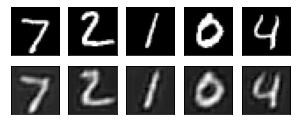

Epoch: 1, Batch: 200, Loss: 0.012684897519648075


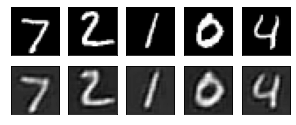

Epoch: 1, Batch: 300, Loss: 0.010272982530295849


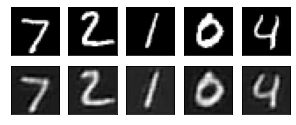

Epoch: 1, Batch: 400, Loss: 0.010138132609426975


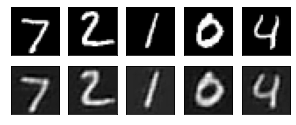

Epoch: 1, Batch: 500, Loss: 0.009824773296713829


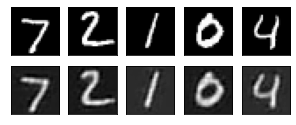

Epoch: 1, Batch: 600, Loss: 0.00929736252874136


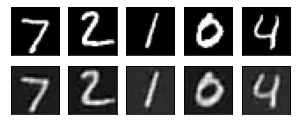

Epoch: 2, Batch: 100, Loss: 0.00971384160220623


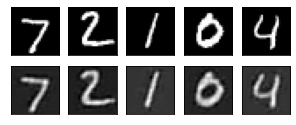

Epoch: 2, Batch: 200, Loss: 0.009189042262732983


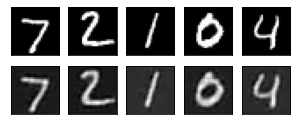

Epoch: 2, Batch: 300, Loss: 0.008846424520015717


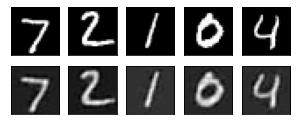

Epoch: 2, Batch: 400, Loss: 0.009010701440274715


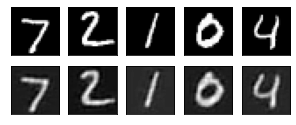

Epoch: 2, Batch: 500, Loss: 0.009018024429678917


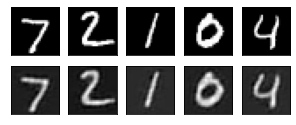

Epoch: 2, Batch: 600, Loss: 0.008903155103325844


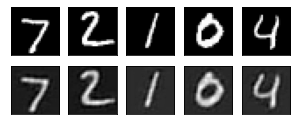

Epoch: 3, Batch: 100, Loss: 0.008482747711241245


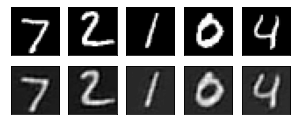

Epoch: 3, Batch: 200, Loss: 0.009378813207149506


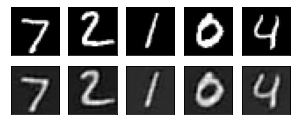

Epoch: 3, Batch: 300, Loss: 0.008159576915204525


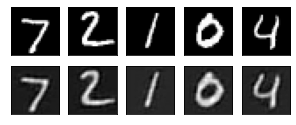

Epoch: 3, Batch: 400, Loss: 0.00841060932725668


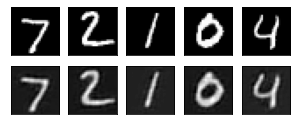

Epoch: 3, Batch: 500, Loss: 0.0087403804063797


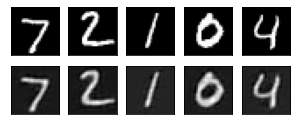

Epoch: 3, Batch: 600, Loss: 0.007279401645064354


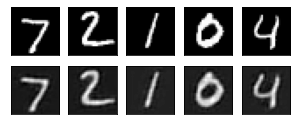

Epoch: 4, Batch: 100, Loss: 0.008087707683444023


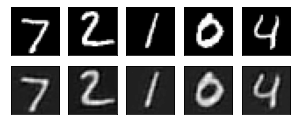

Epoch: 4, Batch: 200, Loss: 0.008951469324529171


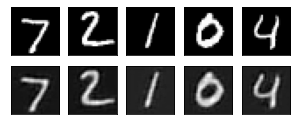

Epoch: 4, Batch: 300, Loss: 0.008041554130613804


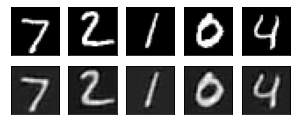

Epoch: 4, Batch: 400, Loss: 0.009601501747965813


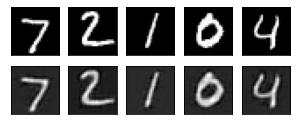

Epoch: 4, Batch: 500, Loss: 0.007945725694298744


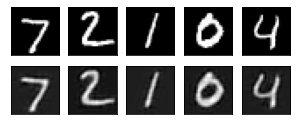

Epoch: 4, Batch: 600, Loss: 0.008165760897099972


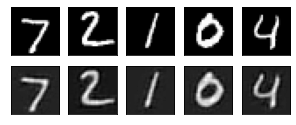

Epoch: 5, Batch: 100, Loss: 0.00716041587293148


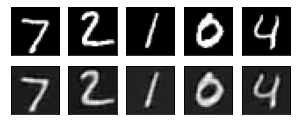

Epoch: 5, Batch: 200, Loss: 0.007900217548012733


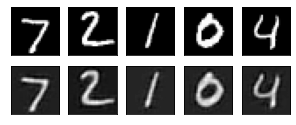

Epoch: 5, Batch: 300, Loss: 0.007197175174951553


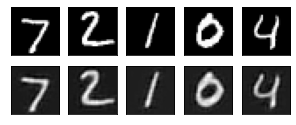

Epoch: 5, Batch: 400, Loss: 0.007047052029520273


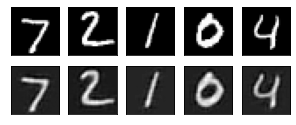

Epoch: 5, Batch: 500, Loss: 0.0074837408028542995


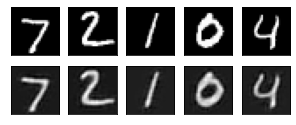

Epoch: 5, Batch: 600, Loss: 0.007538489531725645


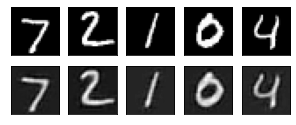

In [8]:
for epoch in range(num_epoch):
  for i, (images, labels) in enumerate(train_loader):
    x = Variable(images).cuda()
    y = Variable(images).cuda()

    encoded, decoded = auto_encoder_cnn(x)

    loss = loss_func(decoded, y) # calculate loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 100 == 0:
      print('Epoch: {}, Batch: {}, Loss: {}'.format(epoch+1, i+1, loss.data))
      figure, index = plt.subplots(2, 5, figsize=(5, 2)) # row, col, and figzise is (2, 5)
      _, decoded_data = auto_encoder_cnn(view_data) # _ is encoded which we don't need here.
      for j in range(5): # 5張圖

        # view_data from variable tensor to numpy. 
        # numpy reshape to image original size. (28, 28)
        
        # row1
        index[0][j].imshow(np.reshape(view_data.data.cpu().numpy()[j], (28, 28)), cmap='gray') # gpu to cpu
        index[0][j].set_xticks(())
        index[0][j].set_yticks(())

        # row2
        index[1][j].imshow(np.reshape(decoded_data.data.cpu().numpy()[j], (28, 28)), cmap='gray') # gpu to cpu 
        index[1][j].set_xticks(())
        index[1][j].set_yticks(())

      plt.draw()
      plt.show()